<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
data = pd.read_csv('taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data.isnull().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime').resample('H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

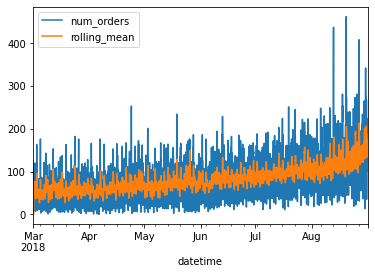

In [6]:
data['rolling_mean'] = data.rolling(10).mean().fillna(0)
data.plot();

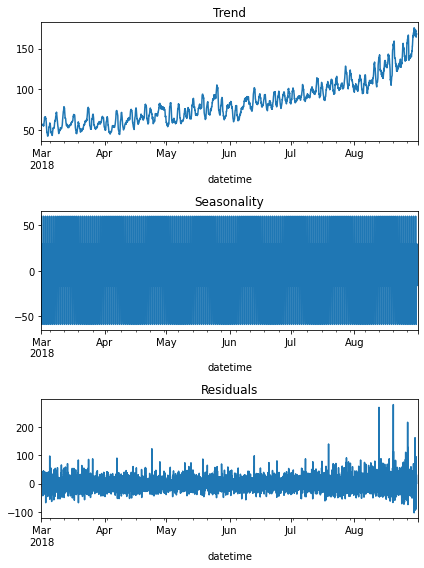

In [7]:
data = data.drop('rolling_mean', axis=1)
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графикам видим, что тренд с ускорением.

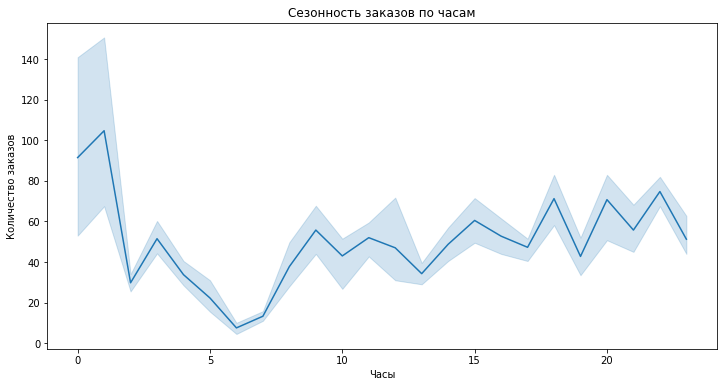

In [8]:
hourly_counts = data['2018-03-03':'2018-03-06'].resample('H').sum()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_counts.index.hour, y=hourly_counts['num_orders'])
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.title('Сезонность заказов по часам')
plt.show()

Можно сделать вывод, что меньше всего заказов ранним утром (~6 часов утра), больше - ближе к полуночи.

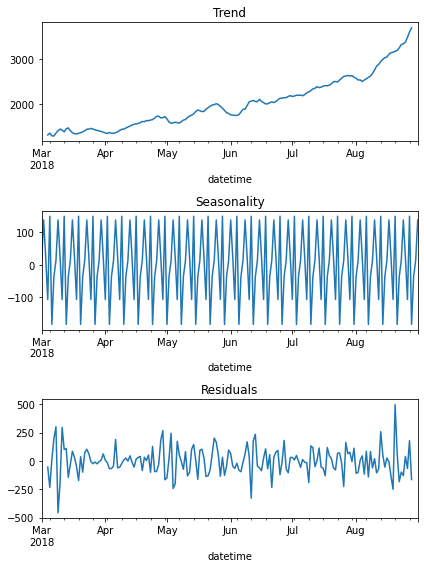

In [9]:
data_d = data.resample('D').sum()

decomposed = seasonal_decompose(data_d) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

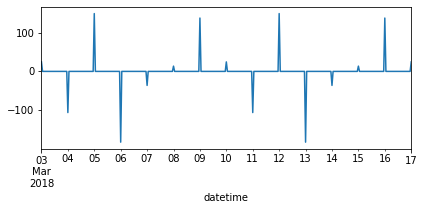

In [10]:
data_1d = data.resample('1D').sum()
decomposed_1d = seasonal_decompose(data_1d)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_1d.seasonal['2018-03-03':'2018-03-17'].resample('H').sum().plot(ax=plt.gca())
plt.tight_layout()

**Вывод:**: тренд с ускорением, сезонность присутствует. Меньше всего заказов ранним утром (~6 часов утра), больше - ближе к полуночи. Выделяем признаки часа, дня и дня недели.

## Обучение

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
make_features(data, 25, 10)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

rmse_scorer = make_scorer(mean_squared_error, squared=False)

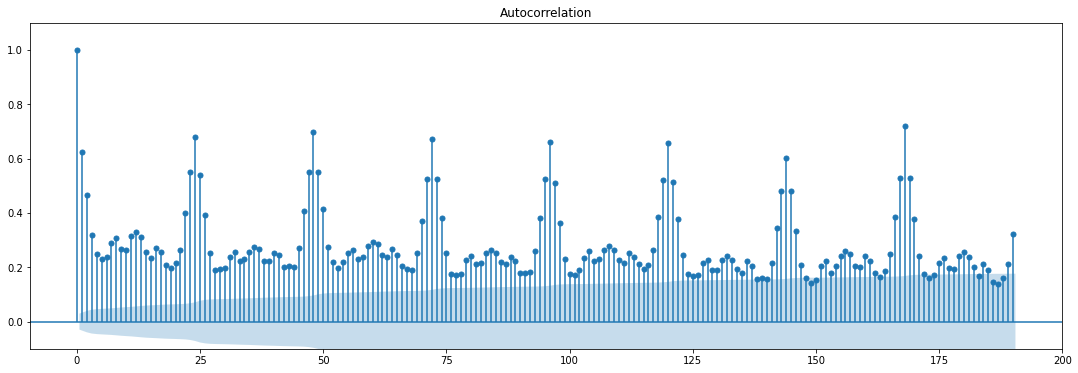

In [13]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

**LinearRegression**

In [14]:
model_lr = LinearRegression()

param_grid_lr = {}
tscv = TimeSeriesSplit(n_splits=5)
grid_search_lr = GridSearchCV(model_lr, param_grid_lr, scoring=rmse_scorer, cv=tscv)
grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_
best_rmse_lr = grid_search_lr.best_score_

print("LinearRegression")
print("RMSE:", best_rmse_lr)
print("Лучшие параметры:", best_params_lr)

LinearRegression
RMSE: 27.17714636960763
Лучшие параметры: {}


**DecisionTreeRegressor**

In [15]:
model_dtr = DecisionTreeRegressor()

param_grid_dtr = {'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4]}

grid_search_dtr = GridSearchCV(estimator=model_dtr, param_grid=param_grid_dtr, scoring=rmse_scorer, cv=tscv)

grid_search_dtr.fit(X_train, y_train)
best_params_dtr = grid_search_dtr.best_params_
best_rmse_dtr = grid_search_dtr.best_score_

print("DecisionTreeRegressor")
print("RMSE:", best_rmse_dtr)
print("Лучшие параметры:", best_params_dtr)

DecisionTreeRegressor
RMSE: 36.16100824769248
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


**GradientBoostingRegressor**

In [16]:
model_gbr = GradientBoostingRegressor()

param_grid_gbr = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.1, 0.05, 0.01]}

grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=param_grid_gbr, scoring=rmse_scorer, cv=tscv)

grid_search_gbr.fit(X_train, y_train)
best_params_gbr = grid_search_dtr.best_params_
best_rmse_gbr = grid_search_dtr.best_score_

print("GradientBoostingRegressor")
print("RMSE:", best_rmse_gbr)
print("Лучшие параметры:", best_params_gbr)

GradientBoostingRegressor
RMSE: 36.16100824769248
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Тестирование

В качестве лучшей модели выберем линейную регрессию ввиду наилучшего результата RMSE во время кросс-валидации.

In [17]:
model_lr.fit(X_train, y_train)
predicted = model_lr.predict(X_test)
print("RMSE линейной регрессии:", mean_squared_error(y_test, predicted, squared=False))

RMSE линейной регрессии: 45.18111201631725


## Вывод

В ходе работы были проанализированы данные, выбраны три модели для обучения - **LinearRegression**, **DecisionTreeRegressor** и **GradientBoostingRegressor**. В качестве модели для тестирования была выбрана линейная регрессия - метрика RMSE на кросс-валидации - 25.8. На тестовой выборке модель показала удовлетворительный результат RMSE - 45.7